# Semantic Segmentation using U-Net

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
import os
from pathlib import Path
import cv2
import random
from torchmetrics.segmentation import MeanIoU
from tqdm import tqdm
import wandb
import time

## Dataset Visualization

In [2]:
# read train and test folders
dataset_path = Path("dataset")
train_images_path = dataset_path / "train" / "images"
train_labels_path = dataset_path / "train" / "labels"
test_images_path = dataset_path / "test" / "images"
test_labels_path = dataset_path / "test" / "labels"

train_file_names = os.listdir(train_images_path)
test_file_names = os.listdir(test_images_path)

# create validation split
val_file_names = train_file_names[:500]
train_file_names = train_file_names[500:]
print(f"Number of training samples: {len(train_file_names)}")
print(f"Number of validation samples: {len(val_file_names)}")
print(f"Number of test samples: {len(test_file_names)}")

Number of training samples: 1500
Number of validation samples: 500
Number of test samples: 500


In [3]:
labels_map = {
    0:"Unlabeled",
    1: "Building",
    2: "Fence",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "RoadLine",
    7: "Road",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Vegetation",
    11: "Car",
    12: "Wall",
    13: "Traffic Sign",
}

# function to show an image with the ground truth masks
def plot_image_with_gt_masks(image_path, label_path):
    image = cv2.imread(image_path)
    label = cv2.imread(label_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)[:,:,0]
    fig, axs = plt.subplots(3, 5, figsize=(20, 10))
    axs = axs.flatten()
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis('off')
    axs[1].imshow(label)
    axs[1].set_title("Label")
    axs[1].axis('off')

    for i in range(0, 13):
        axs[i+2].imshow(label == i)
        axs[i+2].set_title(labels_map[i])
        axs[i+2].axis('off')
        
    plt.suptitle("Image with Ground Truth Masks")
    plt.tight_layout()
    plt.show()

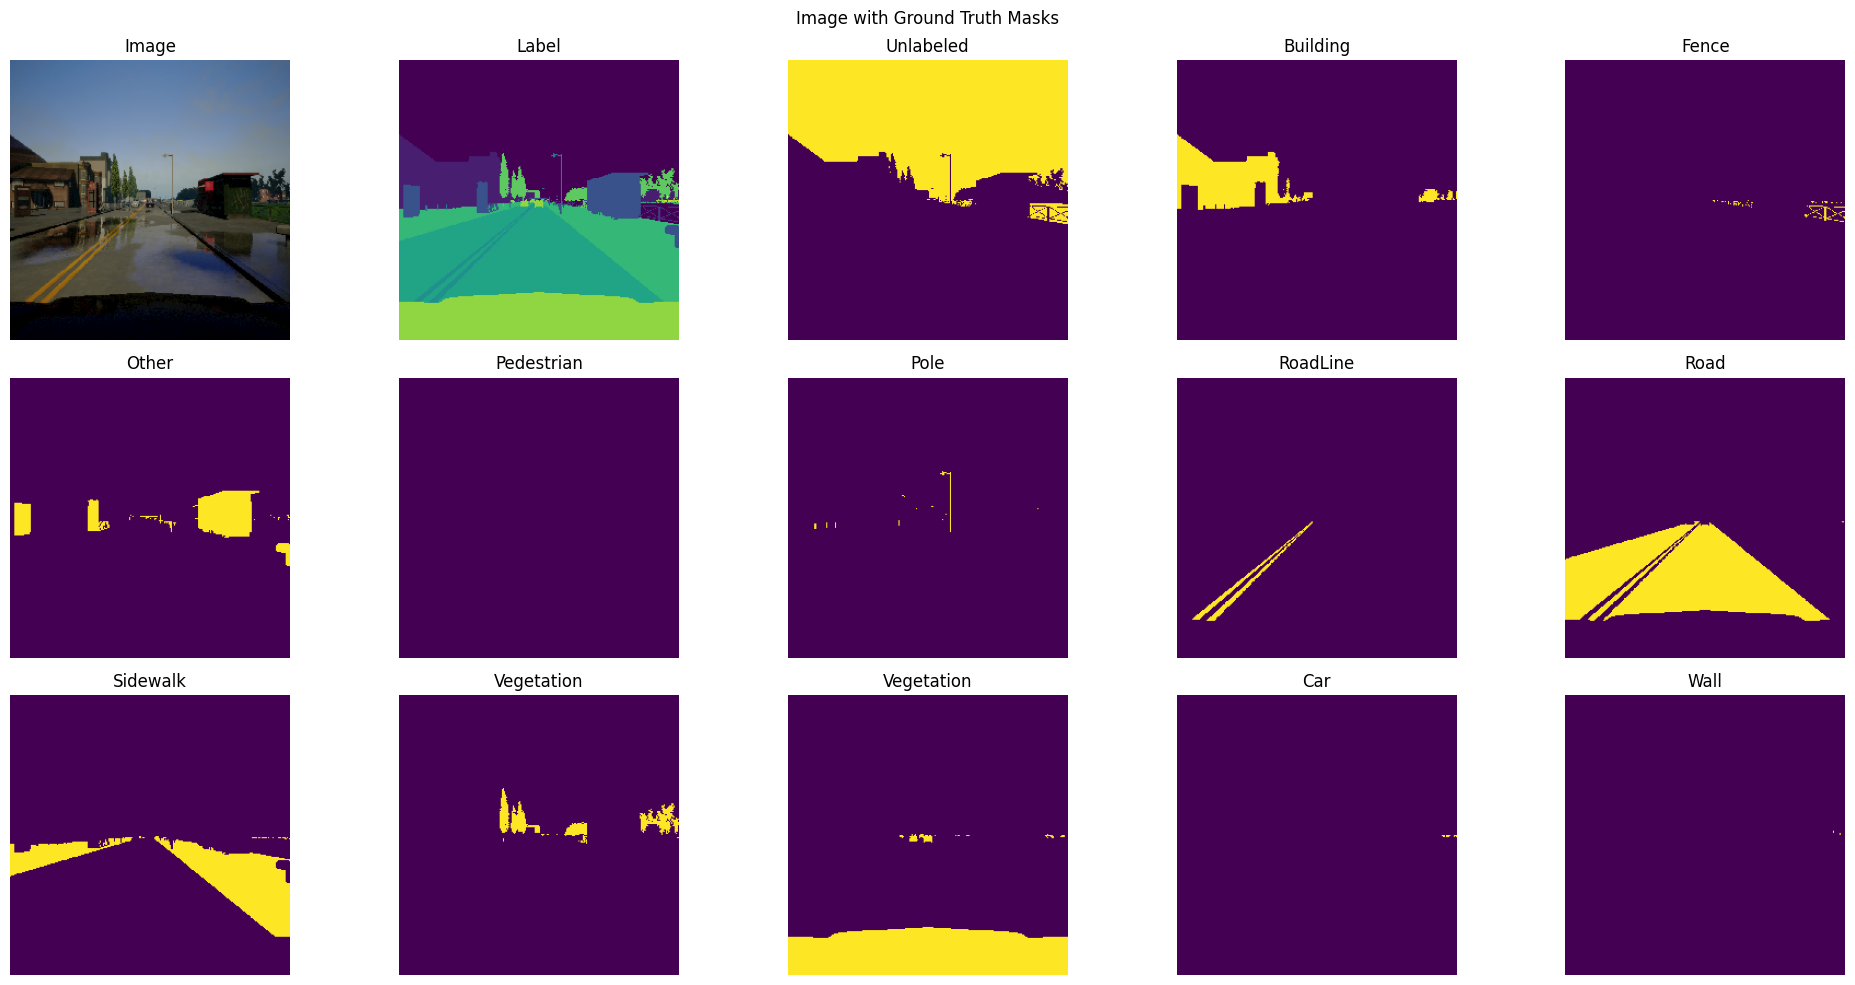

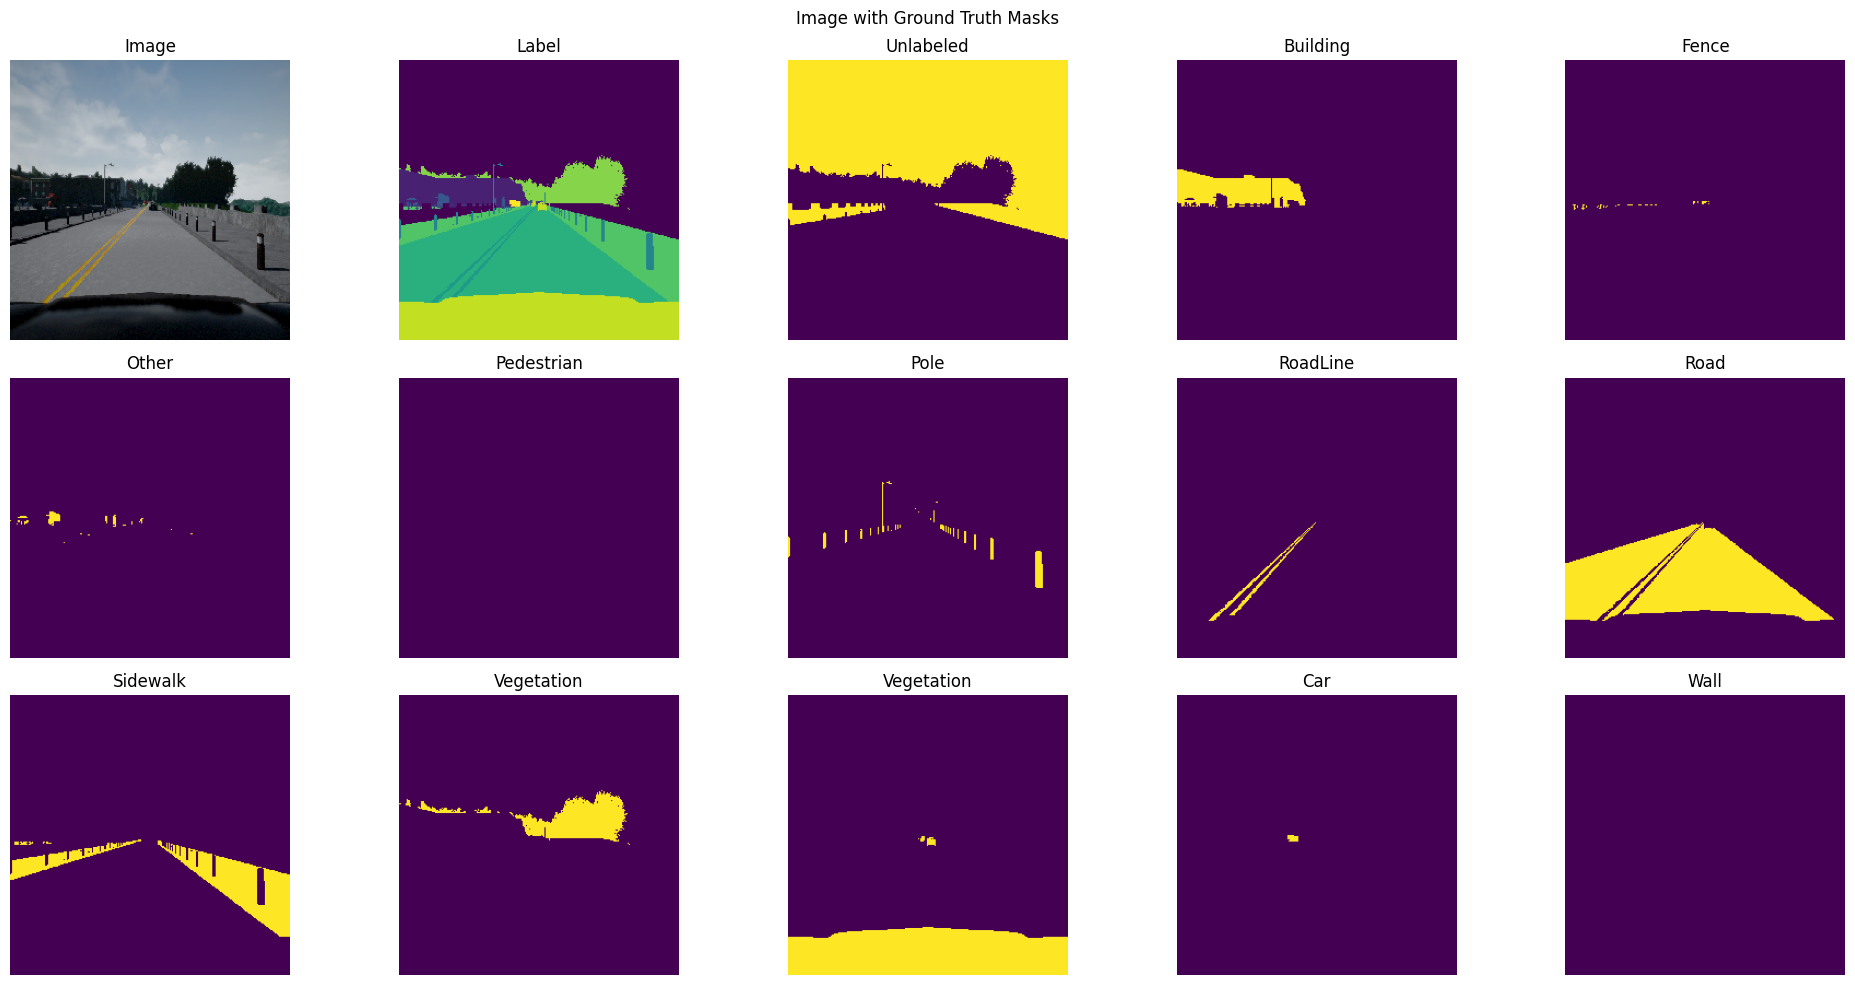

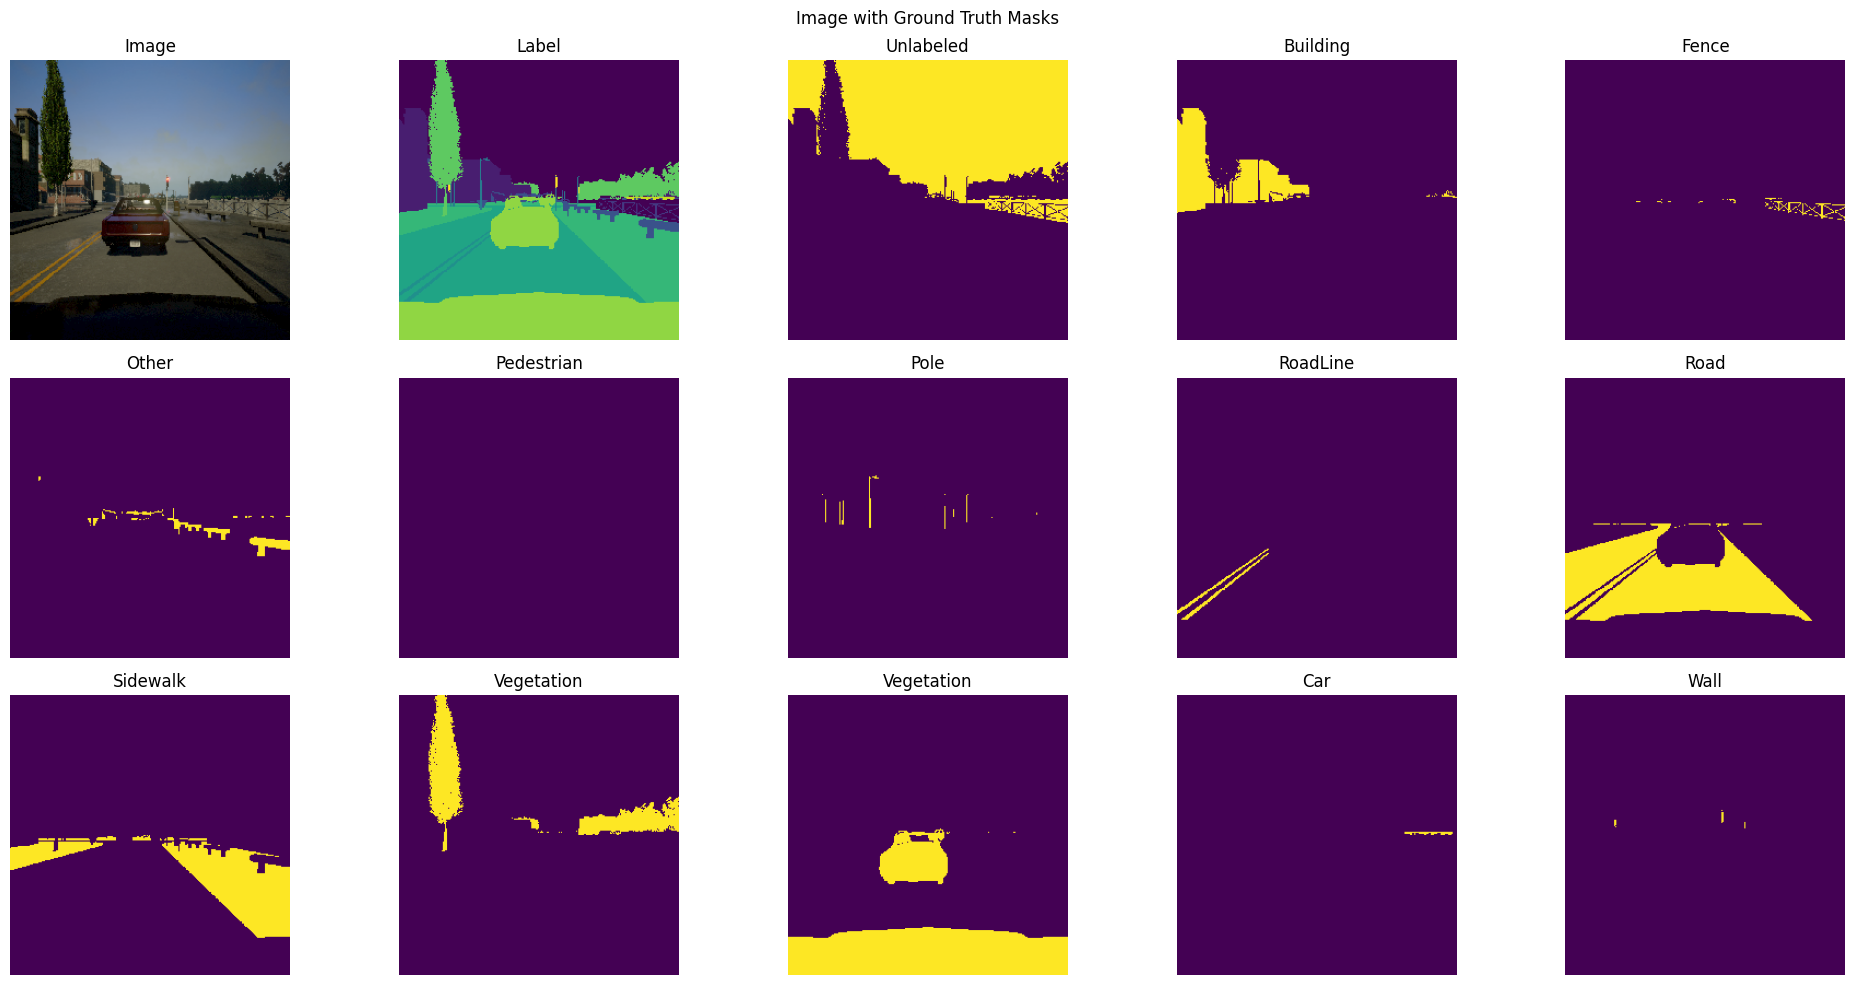

In [4]:
# show random 3 images with ground truth masks
for _ in range(3):
    random_index = random.randint(0, len(train_file_names)-1)
    image_path = train_images_path / train_file_names[random_index]
    label_path = train_labels_path / train_file_names[random_index]
    plot_image_with_gt_masks(image_path, label_path)

In [5]:
# create dataset class
class ImageDataset(Dataset):
    def __init__(self, images_path, labels_path, file_names):
        self.images_path = images_path
        self.labels_path = labels_path
        self.file_names = file_names

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_path, self.file_names[idx])
        label_name = os.path.join(self.labels_path, self.file_names[idx])

        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.from_numpy(image).permute(2, 0, 1) / 255.0
        label = cv2.imread(label_name)[:,:,2]
        label = torch.from_numpy(label).long()
        # label = F.one_hot(label, num_classes=13).permute(2, 0, 1)
        # label = label.float()

        return image, label
    
train_dataset = ImageDataset(train_images_path, train_labels_path, train_file_names)
val_dataset = ImageDataset(train_images_path, train_labels_path, val_file_names)
test_dataset = ImageDataset(test_images_path, test_labels_path, test_file_names)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Training, Evaluation and Visualization functions

In [6]:
# training loop
log_wandb = False
def train_model(model, train_loader, val_loader, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    metric = MeanIoU(num_classes=13).to(device)
    
    for epoch in range(epochs):
        model.train()
        metric.reset()
        train_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            
            metric.update(preds, labels)
        
        train_loss /= len(train_loader)
        train_iou = metric.compute().item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, IoU: {train_iou:.4f}")
        if log_wandb:
            wandb.log({"train_loss": train_loss, "train_iou": train_iou}, step=epoch)
        # validation
        model.eval()
        metric.reset()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                metric.update(preds, labels)
        val_loss /= len(val_loader)
        val_iou = metric.compute().item()
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")
        if log_wandb:
            wandb.log({"val_loss": val_loss, "val_iou": val_iou}, step=epoch)
            
        if epoch % 5 == 0:
            time.sleep(60)

In [7]:
# evaluation loop
def eval_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    metric = MeanIoU(num_classes=13).to(device)
    criterion = nn.CrossEntropyLoss()

    model.eval()
    metric.reset()
    val_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            metric.update(preds, labels)

    val_loss /= len(val_loader)
    val_iou = metric.compute().item()
    print(f"Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

In [ ]:
# show predictions
def show_predictions(model, data_loader, name, count):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            count -= 1
            if count < 0:
                break
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(images[0].cpu().permute(1, 2, 0))
            axs[0].set_title("Image")
            axs[0].axis('off')
            axs[1].imshow(labels[0].cpu().numpy())
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')
            axs[2].imshow(preds[0])
            axs[2].set_title("Prediction")
            axs[2].axis('off')
            plt.suptitle(name)
            plt.show()

## Vanilla U-Net

In [9]:
class VanillaUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=13):
        super(VanillaUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        out = self.final_conv(dec1)
        return out

In [10]:
vanilla_unet = VanillaUNet()
log_wandb = True
if log_wandb:
    wandb.init(project="unet_segmentation", name="Vanilla UNet", config={"model": "Vanilla UNet"})
train_model(vanilla_unet, train_loader, val_loader, epochs=30, lr=0.001)
if log_wandb:
    wandb.finish()

wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 47/47 [00:23<00:00,  1.99it/s]


Epoch 1/30, Loss: 1.0750, IoU: 0.5957
Validation Loss: 1.7932, IoU: 0.4413


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


Epoch 2/30, Loss: 0.4396, IoU: 0.7606
Validation Loss: 0.4121, IoU: 0.7492


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


Epoch 3/30, Loss: 0.3085, IoU: 0.8013
Validation Loss: 0.2890, IoU: 0.8126


100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


Epoch 4/30, Loss: 0.2593, IoU: 0.8128
Validation Loss: 0.2754, IoU: 0.8149


100%|██████████| 47/47 [00:22<00:00,  2.07it/s]


Epoch 5/30, Loss: 0.2145, IoU: 0.8289
Validation Loss: 0.2041, IoU: 0.8399


100%|██████████| 47/47 [00:22<00:00,  2.08it/s]


Epoch 6/30, Loss: 0.1945, IoU: 0.8361
Validation Loss: 0.1910, IoU: 0.8417


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 7/30, Loss: 0.1723, IoU: 0.8461
Validation Loss: 0.1667, IoU: 0.8540


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 8/30, Loss: 0.1557, IoU: 0.8536
Validation Loss: 0.1700, IoU: 0.8478


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 9/30, Loss: 0.1476, IoU: 0.8560
Validation Loss: 0.1514, IoU: 0.8596


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 10/30, Loss: 0.1316, IoU: 0.8635
Validation Loss: 0.1351, IoU: 0.8678


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 11/30, Loss: 0.1205, IoU: 0.8687
Validation Loss: 0.1451, IoU: 0.8612


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 12/30, Loss: 0.1126, IoU: 0.8719
Validation Loss: 0.1204, IoU: 0.8700


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 13/30, Loss: 0.1067, IoU: 0.8744
Validation Loss: 0.1172, IoU: 0.8725


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 14/30, Loss: 0.1001, IoU: 0.8775
Validation Loss: 0.1105, IoU: 0.8788


100%|██████████| 47/47 [00:22<00:00,  2.05it/s]


Epoch 15/30, Loss: 0.0969, IoU: 0.8791
Validation Loss: 0.1204, IoU: 0.8676


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 16/30, Loss: 0.0906, IoU: 0.8819
Validation Loss: 0.0957, IoU: 0.8841


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 17/30, Loss: 0.0845, IoU: 0.8844
Validation Loss: 0.0928, IoU: 0.8859


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 18/30, Loss: 0.0780, IoU: 0.8881
Validation Loss: 0.0848, IoU: 0.8919


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 19/30, Loss: 0.0737, IoU: 0.8908
Validation Loss: 0.0779, IoU: 0.8942


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 20/30, Loss: 0.0710, IoU: 0.8918
Validation Loss: 0.0867, IoU: 0.8889


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 21/30, Loss: 0.0730, IoU: 0.8905
Validation Loss: 0.0806, IoU: 0.8916


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 22/30, Loss: 0.0662, IoU: 0.8944
Validation Loss: 0.0691, IoU: 0.8978


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 23/30, Loss: 0.0605, IoU: 0.8977
Validation Loss: 0.0660, IoU: 0.9001


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 24/30, Loss: 0.0658, IoU: 0.8934
Validation Loss: 0.0857, IoU: 0.8886


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 25/30, Loss: 0.0684, IoU: 0.8923
Validation Loss: 0.0731, IoU: 0.8963


100%|██████████| 47/47 [00:22<00:00,  2.05it/s]


Epoch 26/30, Loss: 0.0577, IoU: 0.8991
Validation Loss: 0.0638, IoU: 0.9009


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 27/30, Loss: 0.0566, IoU: 0.8997
Validation Loss: 0.0599, IoU: 0.9029


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 28/30, Loss: 0.0499, IoU: 0.9035
Validation Loss: 0.0555, IoU: 0.9057


100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch 29/30, Loss: 0.0482, IoU: 0.9043
Validation Loss: 0.0558, IoU: 0.9060


100%|██████████| 47/47 [00:22<00:00,  2.05it/s]


Epoch 30/30, Loss: 0.0480, IoU: 0.9046
Validation Loss: 0.0545, IoU: 0.9058


Evaluating on validation set
Loss: 0.0545, IoU: 0.9058
Evaluating on test set
Loss: 0.0550, IoU: 0.9015


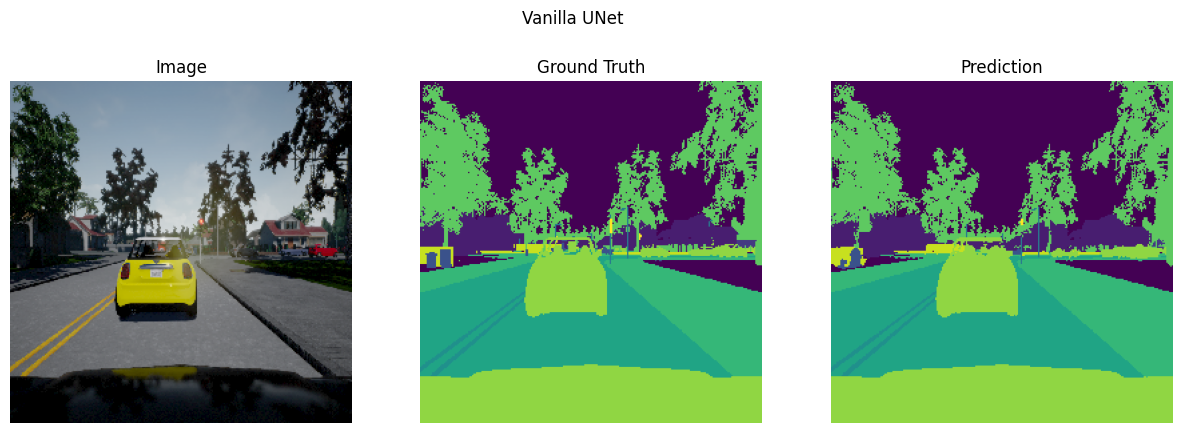

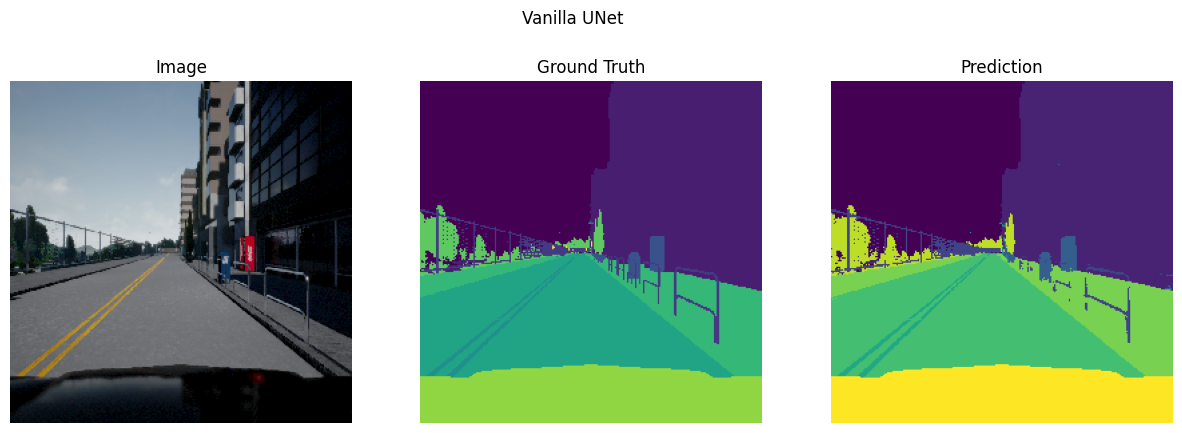

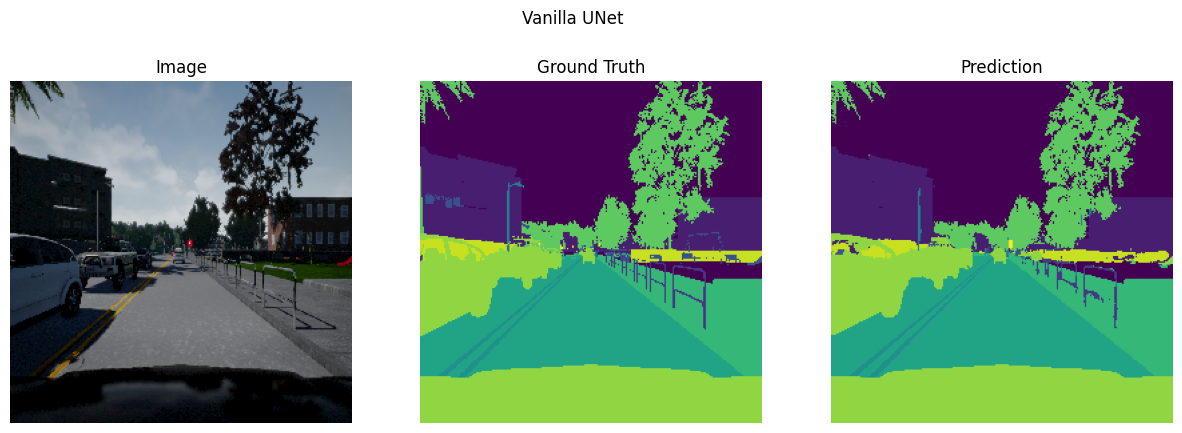

In [12]:
print("Evaluating on validation set")
eval_model(vanilla_unet, val_loader)
print("Evaluating on test set")
eval_model(vanilla_unet, test_loader)
show_predictions(vanilla_unet, test_loader, "Vanilla UNet", 3)

## U-Net without skip connections

In [9]:
class UNetWithoutSkipConn(nn.Module):
    def __init__(self, in_channels=3, out_channels=13):
        super(UNetWithoutSkipConn, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(512, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(256, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        out = self.final_conv(dec1)
        return out

In [10]:
unet_without_skip = UNetWithoutSkipConn()
log_wandb = True
if log_wandb:
    wandb.init(project="unet_segmentation", name="UNetWithoutSkipConn", config={"model": "UNetWithoutSkipConn"})
train_model(unet_without_skip, train_loader, val_loader, epochs=30, lr=0.001)
if log_wandb:
    wandb.finish()

wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 47/47 [00:20<00:00,  2.30it/s]


Epoch 1/30, Loss: 1.4432, IoU: 0.3872
Validation Loss: 1.4459, IoU: 0.3853


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 2/30, Loss: 0.6898, IoU: 0.5959
Validation Loss: 0.7466, IoU: 0.5830


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 3/30, Loss: 0.5340, IoU: 0.6680
Validation Loss: 0.5228, IoU: 0.6599


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 4/30, Loss: 0.4484, IoU: 0.7051
Validation Loss: 0.4966, IoU: 0.6615


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 5/30, Loss: 0.4022, IoU: 0.7214
Validation Loss: 0.4192, IoU: 0.7156


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 6/30, Loss: 0.3555, IoU: 0.7385
Validation Loss: 0.3816, IoU: 0.7296


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 7/30, Loss: 0.3296, IoU: 0.7462
Validation Loss: 0.3240, IoU: 0.7503


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 8/30, Loss: 0.3159, IoU: 0.7492
Validation Loss: 0.4239, IoU: 0.7031


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 9/30, Loss: 0.2900, IoU: 0.7581
Validation Loss: 0.2959, IoU: 0.7526


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 10/30, Loss: 0.2717, IoU: 0.7647
Validation Loss: 0.2844, IoU: 0.7660


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 11/30, Loss: 0.2625, IoU: 0.7673
Validation Loss: 0.2868, IoU: 0.7573


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 12/30, Loss: 0.2550, IoU: 0.7703
Validation Loss: 0.2703, IoU: 0.7716


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 13/30, Loss: 0.2415, IoU: 0.7761
Validation Loss: 0.2619, IoU: 0.7709


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 14/30, Loss: 0.2272, IoU: 0.7812
Validation Loss: 0.2303, IoU: 0.7876


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 15/30, Loss: 0.2180, IoU: 0.7850
Validation Loss: 0.2331, IoU: 0.7756


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 16/30, Loss: 0.2108, IoU: 0.7882
Validation Loss: 0.2370, IoU: 0.7882


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 17/30, Loss: 0.2007, IoU: 0.7917
Validation Loss: 0.2297, IoU: 0.7852


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 18/30, Loss: 0.1913, IoU: 0.7958
Validation Loss: 0.2142, IoU: 0.7950


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 19/30, Loss: 0.1872, IoU: 0.7981
Validation Loss: 0.2077, IoU: 0.7985


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 20/30, Loss: 0.1771, IoU: 0.8026
Validation Loss: 0.1916, IoU: 0.8058


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 21/30, Loss: 0.1727, IoU: 0.8057
Validation Loss: 0.1866, IoU: 0.8046


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 22/30, Loss: 0.1675, IoU: 0.8080
Validation Loss: 0.1813, IoU: 0.8026


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 23/30, Loss: 0.1648, IoU: 0.8093
Validation Loss: 0.1810, IoU: 0.8114


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 24/30, Loss: 0.1576, IoU: 0.8132
Validation Loss: 0.1718, IoU: 0.8096


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 25/30, Loss: 0.1557, IoU: 0.8138
Validation Loss: 0.1724, IoU: 0.8167


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 26/30, Loss: 0.1501, IoU: 0.8170
Validation Loss: 0.1695, IoU: 0.8086


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 27/30, Loss: 0.1521, IoU: 0.8155
Validation Loss: 0.1707, IoU: 0.8153


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 28/30, Loss: 0.1480, IoU: 0.8179
Validation Loss: 0.1674, IoU: 0.8169


100%|██████████| 47/47 [00:20<00:00,  2.33it/s]


Epoch 29/30, Loss: 0.1435, IoU: 0.8195
Validation Loss: 0.1684, IoU: 0.8125


100%|██████████| 47/47 [00:20<00:00,  2.34it/s]


Epoch 30/30, Loss: 0.1478, IoU: 0.8180
Validation Loss: 0.1695, IoU: 0.7989


Evaluating on validation set
Loss: 0.1695, IoU: 0.7989
Evaluating on test set
Loss: 0.1705, IoU: 0.7965


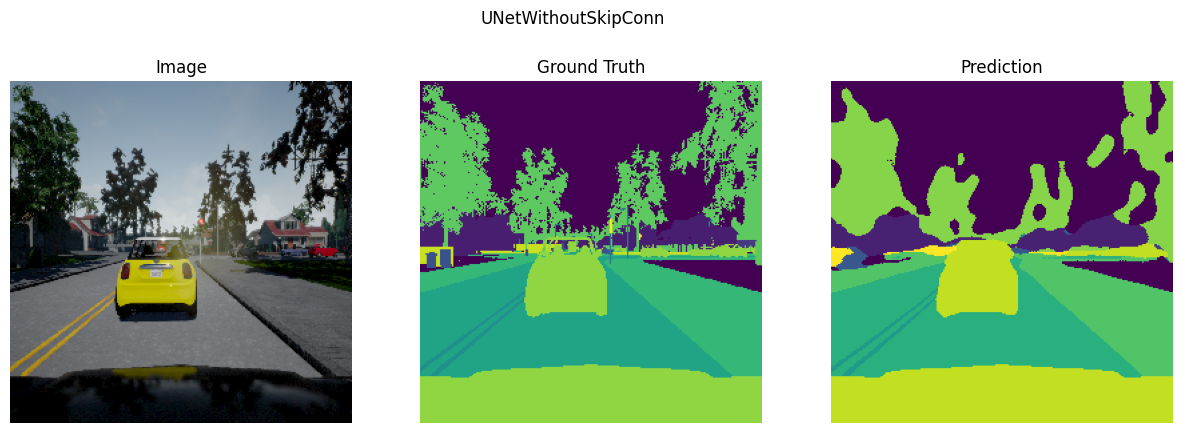

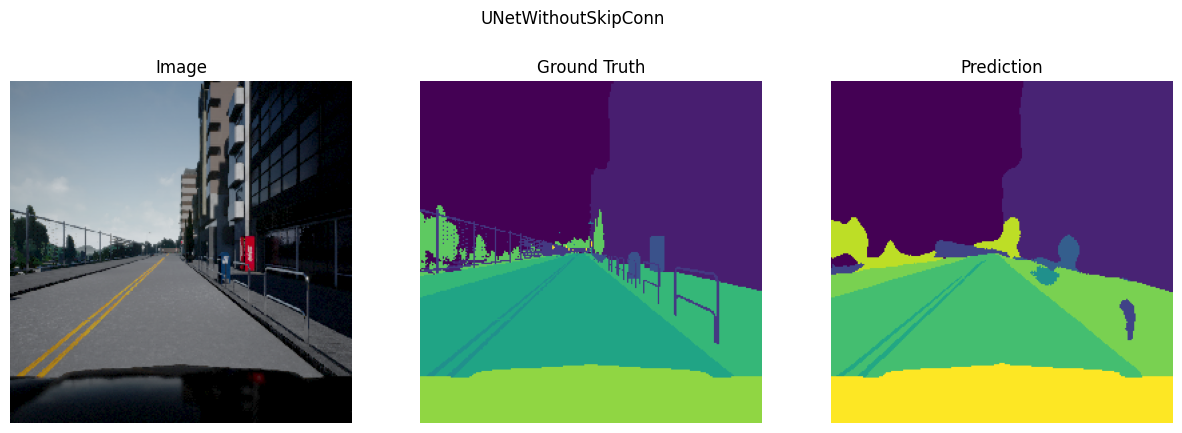

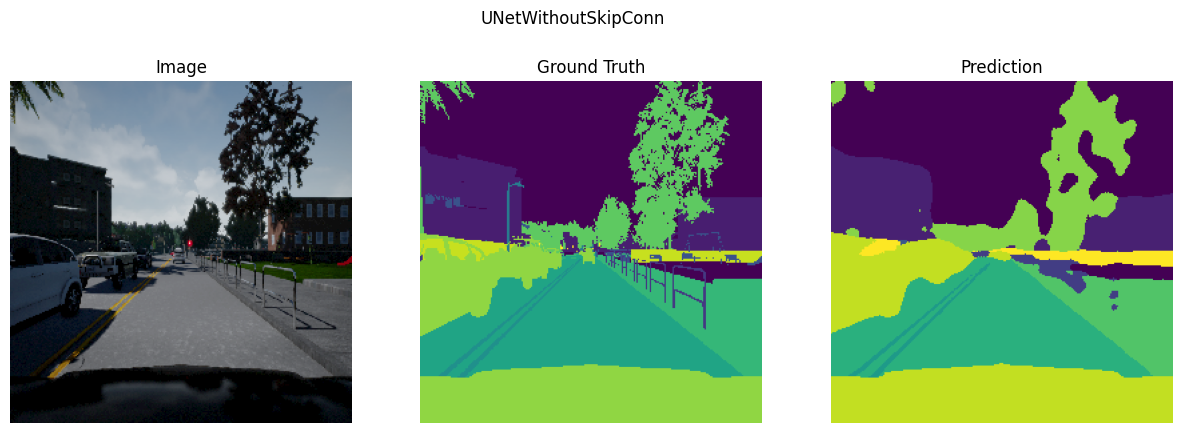

In [11]:
print("Evaluating on validation set")
eval_model(unet_without_skip, val_loader)
print("Evaluating on test set")
eval_model(unet_without_skip, test_loader)
show_predictions(unet_without_skip, test_loader, "UNetWithoutSkipConn", 3)

#### Difference between U-Net and U-Net without skip connections
Removing the skip connections from the U-Net architecture results in 
- Blurry predictions with fine details missing. The boundaries in the segmentation mask are blocky.
- The thin structures like fence, poles are not detected.
- Lower mIoU score.

#### Importance of skip connections in U-Net
- During the downsampling phase, the network loses spatial information. The skip connections help to retain this information by concatenating the feature maps from the encoder to the decoder.
- The skip connections allow the network to learn both high-level and low-level features, which is crucial for accurate segmentation.
- Skip connections allow decoder to align its output with the input image more effectively, leading to better localization of the segmented objects.
- They work like residual connections, allowing gradients to flow more easily through the network during backpropagation. This helps in training deeper networks without suffering from vanishing gradients.

#### Impact of skip connections on performance
- The U-Net with skip connections achieves a higher mIoU score compared to the U-Net without skip connections.
- The U-Net with skip connections produces sharper and more accurate segmentation masks, especially for thin structures and boundaries.

## Residual U-Net

In [12]:
class ResidualUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=13):
        super(ResidualUNet, self).__init__()
        
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels):
                super(ResidualBlock, self).__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                self.bn1 = nn.BatchNorm2d(out_channels)
                self.relu = nn.ReLU(inplace=True)
                self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
                self.bn2 = nn.BatchNorm2d(out_channels)
                if in_channels != out_channels:
                    self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
                else:
                    self.skip = nn.Identity()
                    
            def forward(self, x):
                skip = self.skip(x)
                x = self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))
                x += skip
                x = self.relu(x)
                return x
            
        self.encoder1 = ResidualBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = ResidualBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = ResidualBlock(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = ResidualBlock(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = ResidualBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = ResidualBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = ResidualBlock(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        out = self.final_conv(dec1)
        return out

In [13]:
residual_unet = ResidualUNet()
log_wandb = True
if log_wandb:
    wandb.init(project="unet_segmentation", name="ResidualUNet", config={"model": "ResidualUNet"})
train_model(residual_unet, train_loader, val_loader, epochs=30, lr=0.001)
if log_wandb:
    wandb.finish()

100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 1/30, Loss: 0.8450, IoU: 0.5898
Validation Loss: 0.9927, IoU: 0.4903


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 2/30, Loss: 0.3572, IoU: 0.7600
Validation Loss: 0.3483, IoU: 0.7653


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 3/30, Loss: 0.2684, IoU: 0.7986
Validation Loss: 0.2738, IoU: 0.7994


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 4/30, Loss: 0.2294, IoU: 0.8120
Validation Loss: 0.2418, IoU: 0.8152


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 5/30, Loss: 0.1860, IoU: 0.8310
Validation Loss: 0.1878, IoU: 0.8314


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 6/30, Loss: 0.1715, IoU: 0.8363
Validation Loss: 0.1984, IoU: 0.8181


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 7/30, Loss: 0.1608, IoU: 0.8427
Validation Loss: 0.1697, IoU: 0.8428


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 8/30, Loss: 0.1382, IoU: 0.8550
Validation Loss: 0.1356, IoU: 0.8612


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 9/30, Loss: 0.1313, IoU: 0.8582
Validation Loss: 0.1277, IoU: 0.8679


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 10/30, Loss: 0.1119, IoU: 0.8690
Validation Loss: 0.1105, IoU: 0.8739


100%|██████████| 47/47 [00:25<00:00,  1.88it/s]


Epoch 11/30, Loss: 0.1023, IoU: 0.8740
Validation Loss: 0.1023, IoU: 0.8807


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 12/30, Loss: 0.0990, IoU: 0.8753
Validation Loss: 0.0991, IoU: 0.8801


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 13/30, Loss: 0.0915, IoU: 0.8798
Validation Loss: 0.1030, IoU: 0.8796


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 14/30, Loss: 0.0867, IoU: 0.8824
Validation Loss: 0.0964, IoU: 0.8816


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 15/30, Loss: 0.0809, IoU: 0.8850
Validation Loss: 0.0817, IoU: 0.8890


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 16/30, Loss: 0.0706, IoU: 0.8910
Validation Loss: 0.0767, IoU: 0.8928


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 17/30, Loss: 0.0689, IoU: 0.8917
Validation Loss: 0.0757, IoU: 0.8940


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 18/30, Loss: 0.0665, IoU: 0.8927
Validation Loss: 0.0725, IoU: 0.8930


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 19/30, Loss: 0.0588, IoU: 0.8972
Validation Loss: 0.0622, IoU: 0.9005


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 20/30, Loss: 0.0545, IoU: 0.8997
Validation Loss: 0.0602, IoU: 0.9019


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 21/30, Loss: 0.0518, IoU: 0.9014
Validation Loss: 0.0596, IoU: 0.9015


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 22/30, Loss: 0.0485, IoU: 0.9034
Validation Loss: 0.0614, IoU: 0.9010


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 23/30, Loss: 0.0480, IoU: 0.9037
Validation Loss: 0.0576, IoU: 0.9033


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 24/30, Loss: 0.0446, IoU: 0.9054
Validation Loss: 0.0551, IoU: 0.9045


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 25/30, Loss: 0.0444, IoU: 0.9050
Validation Loss: 0.0558, IoU: 0.9053


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 26/30, Loss: 0.0419, IoU: 0.9070
Validation Loss: 0.0520, IoU: 0.9069


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 27/30, Loss: 0.0400, IoU: 0.9080
Validation Loss: 0.0523, IoU: 0.9062


100%|██████████| 47/47 [00:24<00:00,  1.88it/s]


Epoch 28/30, Loss: 0.0430, IoU: 0.9059
Validation Loss: 0.0571, IoU: 0.9034


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 29/30, Loss: 0.0397, IoU: 0.9082
Validation Loss: 0.0467, IoU: 0.9094


100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


Epoch 30/30, Loss: 0.0351, IoU: 0.9112
Validation Loss: 0.0467, IoU: 0.9100


Evaluating on validation set
Loss: 0.0467, IoU: 0.9100
Evaluating on test set
Loss: 0.0481, IoU: 0.9053


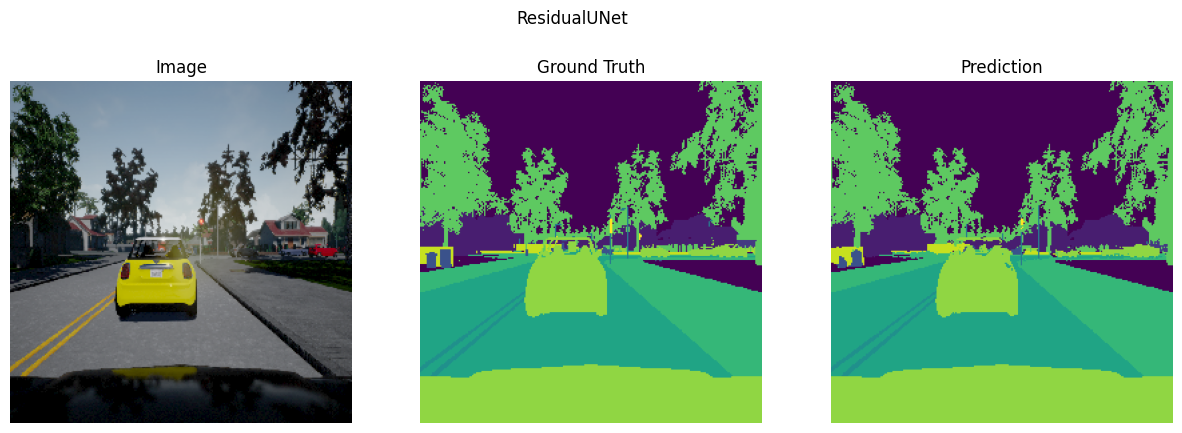

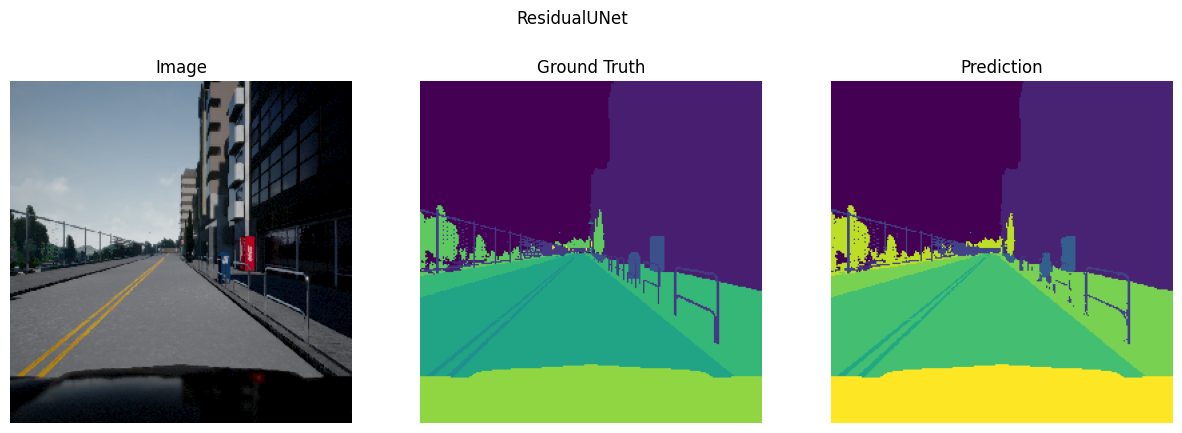

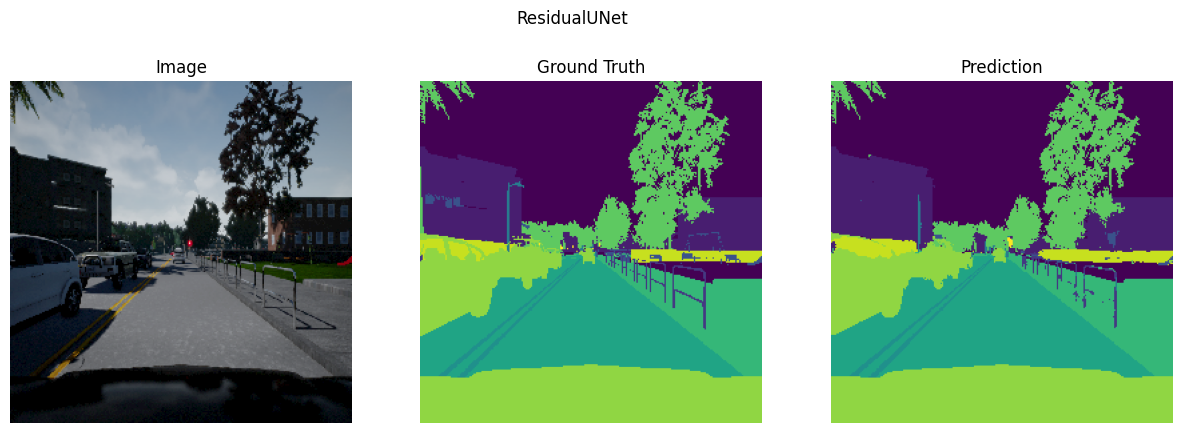

In [14]:
print("Evaluating on validation set")
eval_model(residual_unet, val_loader)
print("Evaluating on test set")
eval_model(residual_unet, test_loader)
show_predictions(residual_unet, test_loader, "ResidualUNet", 3)

## Gated Attention U-Net

In [15]:
class GatedAttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=13):
        super(GatedAttentionUNet, self).__init__()
        
        class AttentionGate(nn.Module):
            def __init__(self, in_channels, gating_channels, inter_channels):
                super(AttentionGate, self).__init__()
                self.W_g = nn.Sequential(
                    nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0),
                    nn.BatchNorm2d(inter_channels)
                )
                self.W_x = nn.Sequential(
                    nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0),
                    nn.BatchNorm2d(inter_channels)
                )
                self.psi = nn.Sequential(
                    nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0),
                    nn.BatchNorm2d(1),
                    nn.Sigmoid()
                )
                
            def forward(self, x, g):
                g1 = self.W_g(g)
                x1 = self.W_x(x)
                psi = F.relu(g1 + x1)
                psi = self.psi(psi)
                return x * psi
            
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attgate4 = AttentionGate(in_channels=512, gating_channels=512, inter_channels=256)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attgate3 = AttentionGate(in_channels=256, gating_channels=256, inter_channels=128)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attgate2 = AttentionGate(in_channels=128, gating_channels=128, inter_channels=64)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attgate1 = AttentionGate(in_channels=64, gating_channels=64, inter_channels=32)
        self.decoder1 = conv_block(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        att4 = self.attgate4(enc4, dec4)
        dec4 = self.decoder4(torch.cat((dec4, att4), dim=1))
        dec3 = self.upconv3(dec4)
        att3 = self.attgate3(enc3, dec3)
        dec3 = self.decoder3(torch.cat((dec3, att3), dim=1))
        dec2 = self.upconv2(dec3)
        att2 = self.attgate2(enc2, dec2)
        dec2 = self.decoder2(torch.cat((dec2, att2), dim=1))
        dec1 = self.upconv1(dec2)
        att1 = self.attgate1(enc1, dec1)
        dec1 = self.decoder1(torch.cat((dec1, att1), dim=1))
        out = self.final_conv(dec1)
        return out

In [16]:
gated_attention_unet = GatedAttentionUNet()
log_wandb = True
if log_wandb:
    wandb.init(project="unet_segmentation", name="GatedAttentionUNet", config={"model": "GatedAttentionUNet"})
train_model(gated_attention_unet, train_loader, val_loader, epochs=30, lr=0.001)
if log_wandb:
    wandb.finish()

100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 1/30, Loss: 1.1465, IoU: 0.5678
Validation Loss: 1.2741, IoU: 0.4963


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 2/30, Loss: 0.4779, IoU: 0.7354
Validation Loss: 0.4111, IoU: 0.7631


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 3/30, Loss: 0.3228, IoU: 0.7937
Validation Loss: 0.3471, IoU: 0.7799


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 4/30, Loss: 0.2701, IoU: 0.8086
Validation Loss: 0.3070, IoU: 0.7825


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 5/30, Loss: 0.2333, IoU: 0.8208
Validation Loss: 0.2231, IoU: 0.8266


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 6/30, Loss: 0.2050, IoU: 0.8290
Validation Loss: 0.2023, IoU: 0.8358


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 7/30, Loss: 0.1875, IoU: 0.8375
Validation Loss: 0.1782, IoU: 0.8482


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 8/30, Loss: 0.1596, IoU: 0.8510
Validation Loss: 0.1924, IoU: 0.8379


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 9/30, Loss: 0.1472, IoU: 0.8563
Validation Loss: 0.1530, IoU: 0.8587


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 10/30, Loss: 0.1344, IoU: 0.8626
Validation Loss: 0.1364, IoU: 0.8671


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 11/30, Loss: 0.1273, IoU: 0.8648
Validation Loss: 0.1329, IoU: 0.8687


100%|██████████| 47/47 [00:25<00:00,  1.87it/s]


Epoch 12/30, Loss: 0.1163, IoU: 0.8696
Validation Loss: 0.1355, IoU: 0.8634


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 13/30, Loss: 0.1081, IoU: 0.8743
Validation Loss: 0.1098, IoU: 0.8788


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 14/30, Loss: 0.1030, IoU: 0.8761
Validation Loss: 0.1213, IoU: 0.8743


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 15/30, Loss: 0.1141, IoU: 0.8706
Validation Loss: 0.1079, IoU: 0.8792


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 16/30, Loss: 0.0946, IoU: 0.8802
Validation Loss: 0.0953, IoU: 0.8856


100%|██████████| 47/47 [00:25<00:00,  1.87it/s]


Epoch 17/30, Loss: 0.0838, IoU: 0.8855
Validation Loss: 0.2425, IoU: 0.8208


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 18/30, Loss: 0.1099, IoU: 0.8705
Validation Loss: 0.1084, IoU: 0.8745


100%|██████████| 47/47 [00:25<00:00,  1.85it/s]


Epoch 19/30, Loss: 0.0858, IoU: 0.8845
Validation Loss: 0.0838, IoU: 0.8912


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 20/30, Loss: 0.0736, IoU: 0.8908
Validation Loss: 0.0779, IoU: 0.8937


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 21/30, Loss: 0.0687, IoU: 0.8935
Validation Loss: 0.0724, IoU: 0.8967


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 22/30, Loss: 0.0646, IoU: 0.8955
Validation Loss: 0.0720, IoU: 0.8964


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 23/30, Loss: 0.0628, IoU: 0.8964
Validation Loss: 0.0667, IoU: 0.8998


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 24/30, Loss: 0.0634, IoU: 0.8956
Validation Loss: 0.0684, IoU: 0.8982


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 25/30, Loss: 0.0590, IoU: 0.8981
Validation Loss: 0.0665, IoU: 0.8994


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 26/30, Loss: 0.0582, IoU: 0.8984
Validation Loss: 0.0649, IoU: 0.9005


100%|██████████| 47/47 [00:25<00:00,  1.87it/s]


Epoch 27/30, Loss: 0.0545, IoU: 0.9007
Validation Loss: 0.0601, IoU: 0.9032


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 28/30, Loss: 0.0520, IoU: 0.9022
Validation Loss: 0.0595, IoU: 0.9033


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 29/30, Loss: 0.0501, IoU: 0.9030
Validation Loss: 0.0572, IoU: 0.9044


100%|██████████| 47/47 [00:25<00:00,  1.86it/s]


Epoch 30/30, Loss: 0.0467, IoU: 0.9053
Validation Loss: 0.0546, IoU: 0.9057


Evaluating on validation set
Loss: 0.0546, IoU: 0.9057
Evaluating on test set
Loss: 0.0555, IoU: 0.9007


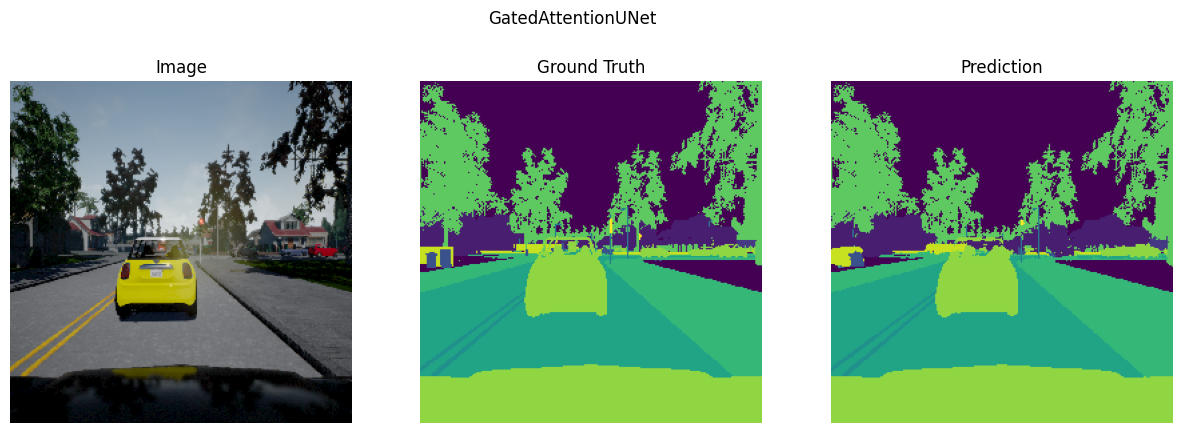

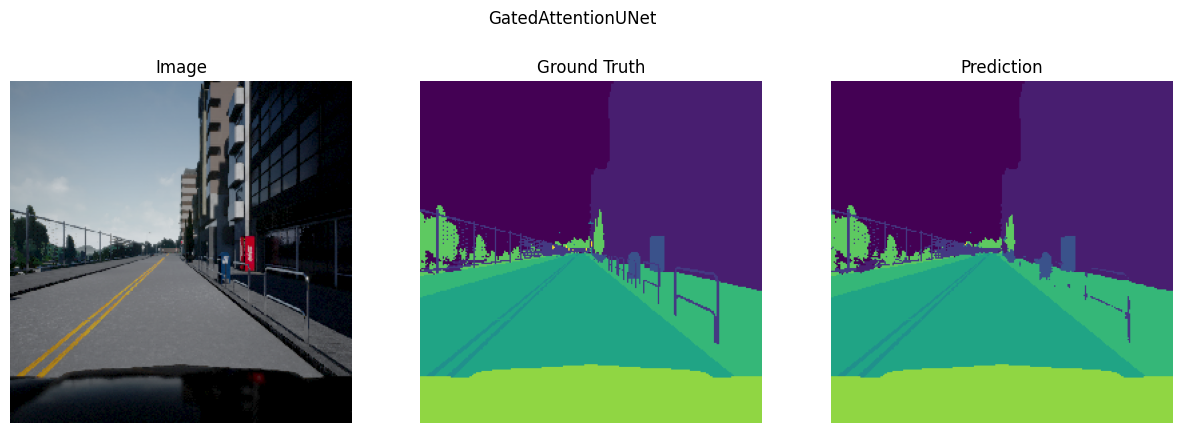

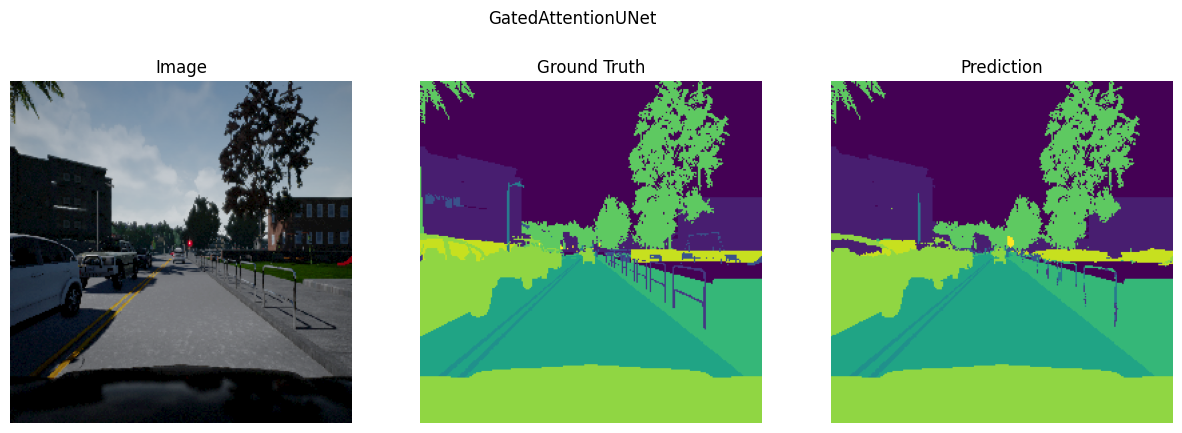

In [17]:
print("Evaluating on validation set")
eval_model(gated_attention_unet, val_loader)
print("Evaluating on test set")
eval_model(gated_attention_unet, test_loader)
show_predictions(gated_attention_unet, test_loader, "GatedAttentionUNet", 3)

#### Advantages of Attention Gates
- Attention gates allow the network to focus on relevant features and suppress irrelevant ones, leading to better segmentation performance.
- When the target object is small or occluded, AG uses the gated signal from the decoder to focus on the relevant features in the encoder, improving the segmentation of small or occluded objects.
- AGs are computationally efficient and can be easily integrated into existing architectures without significant changes to the overall structure. They are learned during training, allowing the network to adaptively learn which features to focus on for a given task acting like soft attention.
  
#### Difference between U-Net and Gated Attention U-Net
- There is almost no difference in the results of U-Net and Gated Attention U-Net. The mIoU score is almost the same.
- The reason for this has to do with the dataset. The dataset is relatively simple, and the objects are not occluded or small. Therefore, the attention gates do not have a significant impact on the performance of the network.
- The Gated Attention U-Net is more beneficial in complex datasets where the objects are small, occluded, or have complex shapes.
- Another reason for the similar performance is the less data in the dataset. AGs require enough data to understand where to focus

### Overall Comparison

![](images/table.png)

![](images/curves.png)

- **GatedAttentionUNet**: Achieves high mIoU with slightly improved generalization, though gains over vanilla U-Net are marginal.

- **ResidualUNet**: Performs the best overall, benefiting from better gradient flow and feature reuse via residual connections.
  
- **UNetWithoutSkipConn**: Shows significantly lower performance, highlighting the critical importance of skip connections in preserving spatial details.
  
- **Vanilla UNet**: Strong baseline with balanced training and validation metrics, confirming its effectiveness for semantic segmentation.